<a href="https://colab.research.google.com/github/azarizz/ta/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


Distribusi label setelah SMOTE: [947 947 947]

--- Evaluasi metrik: COSINE ---


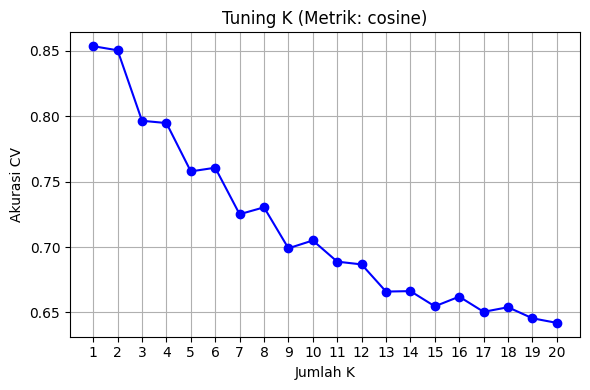


Akurasi Test dengan K=1: 0.6553
              precision    recall  f1-score   support

     negatif       0.85      0.75      0.80       237
      netral       0.29      0.27      0.28        45
     positif       0.31      0.55      0.39        40

    accuracy                           0.66       322
   macro avg       0.48      0.52      0.49       322
weighted avg       0.70      0.66      0.67       322



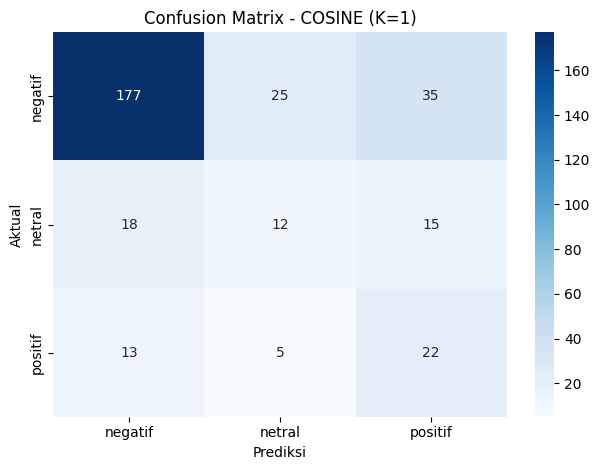


--- Evaluasi metrik: EUCLIDEAN ---


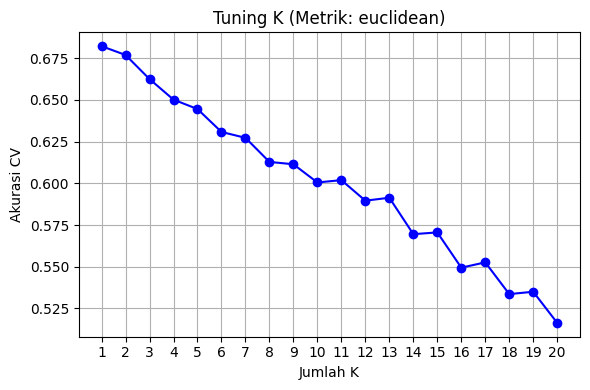


Akurasi Test dengan K=1: 0.2422
              precision    recall  f1-score   support

     negatif       0.91      0.09      0.16       237
      netral       0.17      0.80      0.27        45
     positif       0.26      0.53      0.35        40

    accuracy                           0.24       322
   macro avg       0.45      0.47      0.26       322
weighted avg       0.73      0.24      0.20       322



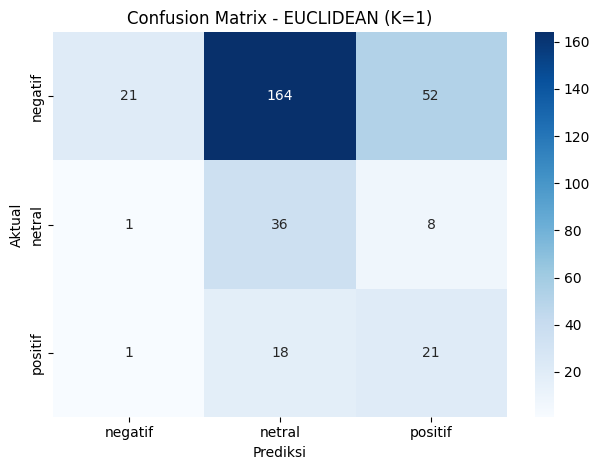


--- Evaluasi metrik: MANHATTAN ---


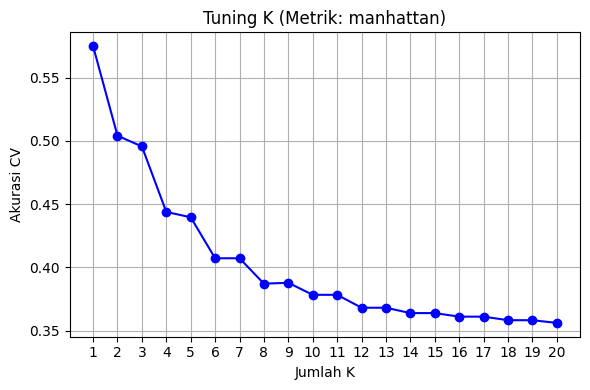


Akurasi Test dengan K=1: 0.1801
              precision    recall  f1-score   support

     negatif       0.92      0.05      0.09       237
      netral       0.14      0.98      0.25        45
     positif       1.00      0.07      0.14        40

    accuracy                           0.18       322
   macro avg       0.69      0.37      0.16       322
weighted avg       0.82      0.18      0.12       322



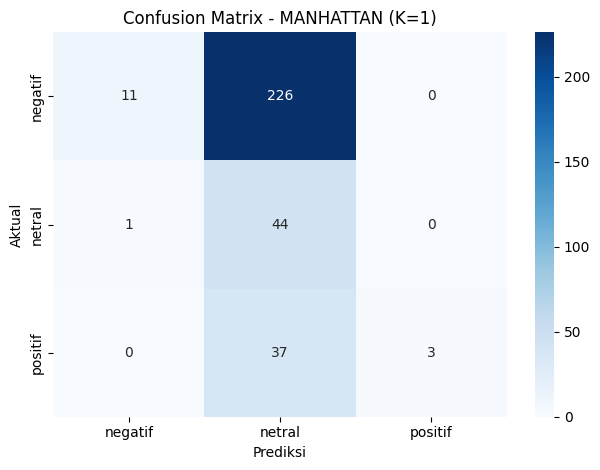

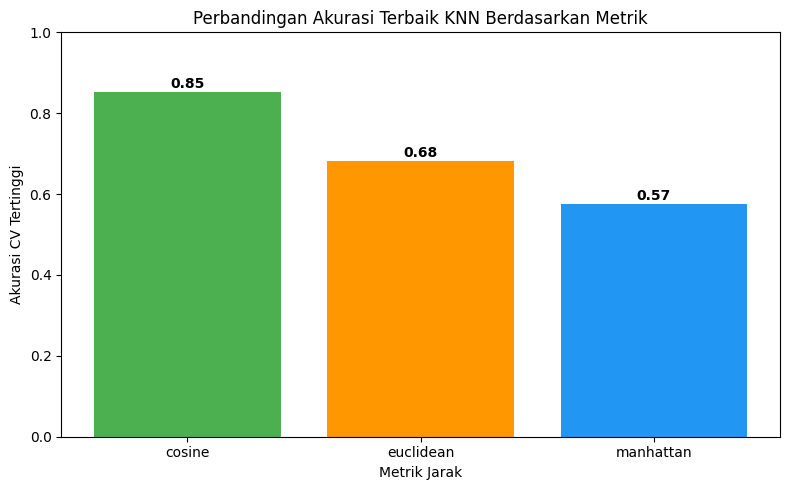

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# =============================
# 1. Load Lexicon
# =============================
positive_df = pd.read_csv("positive.tsv", sep="\t", header=None)
negative_df = pd.read_csv("negative.tsv", sep="\t", header=None)

lexicon_positif = set(positive_df[0].astype(str).str.lower().tolist())
lexicon_negatif = set(negative_df[0].astype(str).str.lower().tolist())

lexicon = {word: 1 for word in lexicon_positif}
lexicon.update({word: -1 for word in lexicon_negatif})

def lexicon_score(text):
    score = sum([lexicon.get(word, 0) for word in text.split()])
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'

# =============================
# 2. Preprocessing Function
# =============================
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()
    tokens = text.split()
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

# =============================
# 3. Load Dataset & Labeling
# =============================
df1 = pd.read_csv("dataset_playstore_terbaru.csv")
df2 = pd.read_csv("IG_Comments_Formatted_Like_PlayStore.csv")

if 'komentar' not in df2.columns:
    df2.rename(columns={'content': 'komentar'}, inplace=True)

df_all = pd.concat([df1, df2], ignore_index=True)
df_all.dropna(subset=['komentar'], inplace=True)
df_all.drop_duplicates(subset=['komentar'], inplace=True)

df_all['clean_text'] = df_all['komentar'].apply(preprocess)
df_all['label'] = df_all['clean_text'].apply(lexicon_score)

# Hapus label netral
#df_all = df_all[df_all['label'] != 'netral']

# =============================
# 4. TF-IDF + Encode Label
# =============================
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_all['clean_text'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_all['label'])

# =============================
# 5. Train-test Split + SMOTE
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribusi label setelah SMOTE:", np.bincount(y_train_res))

# =============================
# 6. Tuning K (1-20) untuk 3 Metrik
# =============================
metrics = {
    'cosine': 'cosine',
    'euclidean': 'euclidean',
    'manhattan': 'manhattan'
}

best_scores = {}

for name, metric in metrics.items():
    print(f"\n--- Evaluasi metrik: {name.upper()} ---")
    cv_scores = []
    k_values = range(1, 21)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X_train_res, y_train_res, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    best_k = k_values[np.argmax(cv_scores)]
    best_acc = max(cv_scores)
    best_scores[name] = {
        'k': best_k,
        'accuracy': best_acc
    }

    # Plot tuning K
    plt.figure(figsize=(6,4))
    plt.plot(k_values, cv_scores, marker='o', color='blue')
    plt.title(f'Tuning K (Metrik: {name})')
    plt.xlabel('Jumlah K')
    plt.ylabel('Akurasi CV')
    plt.xticks(k_values)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluasi akhir dengan K terbaik
    knn_best = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    knn_best.fit(X_train_res, y_train_res)
    y_pred = knn_best.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\nAkurasi Test dengan K={best_k}: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {name.upper()} (K={best_k})")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()
    plt.show()

# =============================
# 7. Visualisasi Perbandingan Akurasi Terbaik
# =============================
plt.figure(figsize=(8,5))
plt.bar(best_scores.keys(),
        [v['accuracy'] for v in best_scores.values()],
        color=['#4CAF50', '#FF9800', '#2196F3'])
plt.title("Perbandingan Akurasi Terbaik KNN Berdasarkan Metrik")
plt.xlabel("Metrik Jarak")
plt.ylabel("Akurasi CV Tertinggi")
plt.ylim(0, 1)
for i, (metric, score) in enumerate(best_scores.items()):
    plt.text(i, score['accuracy'] + 0.01, f"{score['accuracy']:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
